In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ericBayless/bib-detector

Cloning into 'bib-detector'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 241 (delta 53), reused 86 (delta 28), pack-reused 124
Receiving objects: 100% (241/241), 94.61 MiB | 37.15 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [ ]:
import cv2 as cv
import numpy as np
import scipy.io as sio
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Bib detection model config
bd_configPath = '/content/bib-detector/Data/YOLO/bib_detector/RBNR2_custom-yolov4-tiny-detector.cfg'
bd_weightsPath = '/content/bib-detector/Data/YOLO/bib_detector/RBNR2_custom-yolov4-tiny-detector_best.weights'
bd_classes = ['bib']

# Number reader config
nr_configPath = '/content/bib-detector/Data/YOLO/num_reader/SVHN3_custom-yolov4-tiny-detector.cfg'
nr_weightsPath = '/content/bib-detector/Data/YOLO/num_reader/SVHN3_custom-yolov4-tiny-detector_best.weights'
nr_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# True bounding box color
true_color = [15, 252, 75]
# Pred Bib bounding box color
color = [252, 15, 192]

In [ ]:
class Detector:
    """
    Create YOLO object detection model in OpenCV with a given config and weights.
    Use this model to make predictions.
    
    Attributes
        classes (list): list of class names
        net (obj): openCV network object
        ln (obj): openCV layer names object
    """
    
    def __init__(self, cfg, wts, classes):
        """Initialize detector object
        
        Args
            cfg (str): path to model config file
            wts (str): path to model weights file
            classes (list): list of class names
        """
        
        self.classes = classes
        self.net = cv.dnn.readNetFromDarknet(cfg, wts)
        self.net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

        # determine the output layer
        self.ln = self.net.getLayerNames()
        
#         print(self.ln)
#         print(len(self.ln))
        
#         print(self.net.getUnconnectedOutLayers())
        
        self.ln = [self.ln[i - 1] for i in self.net.getUnconnectedOutLayers()]
        
    def detect(self, img, conf):
        """
        Make predictions and return classes and bounding boxes
        
        Args
            img (numpy array): image array from openCV .imread
            conf (float): prediction confidence threshold
            
        Returns
            List containing bounding box values and class names for detections
            in the form [<class name>, [x, y, width, height]]
        """
        
        #format image for detection
        blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
        
         # get detections
        self.net.setInput(blob)
        outputs = self.net.forward(self.ln)

        # initialize lists
        boxes = []
        confidences = []
        classIDs = []

        # initialize image dimensions
        h_img, w_img = img.shape[:2]

        for output in outputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                # drop low confidence detections and 
                if confidence > conf:
                    box = detection[:4] * np.array([w_img, h_img, w_img, h_img])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    box = [x, y, int(width), int(height)]
                    boxes.append(box)
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        # apply non maximal suppression for
        # initialize lists
        self.boxes = []
        self.confidences = []
        self.detected_classes = []
        cls_and_box = []
        # get indices of final bounding boxes  
        indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        if len(indices) > 0:
            for i in indices.flatten():
                self.boxes.append(boxes[i])
                self.confidences.append(confidences[i])
                self.detected_classes.append(self.classes[classIDs[i]])
                
                cls_and_box.append([self.classes[classIDs[i]], boxes[i]])
        
        return cls_and_box

In [ ]:
# Instantiate detectors
bd = Detector(bd_configPath, bd_weightsPath, bd_classes)
nr = Detector(nr_configPath, nr_weightsPath, nr_classes)

def get_rbns(img, single=False):
    """
    Given an image return bib numbers and bib bounding boxes for detected bibs
    
    Args
        img (numpy array): image array given by openCV .imread
        single (bool): whether one or many bib detections will be
            returned.  If true, return detection with largest bounding
            box area.
            
    Returns
        List of detected bib numbers and corresponding bounding boxes in
        the format [<bib number>, [x, y, width, height]]
    """
    


    # Make bib location predictions
    bib_detections = bd.detect(img, 0.25)


    if len(bib_detections) > 0:
        for obj in bib_detections:
            # crop out detected bib
            (x, y, w, h) = obj[1]
            obj.append(w * h)
            crop_img = img[y:y+h, x:x+w]
            
            # detect numbers on bib
            num_detections = nr.detect(crop_img, 0.5)
            bib_digit_loc = []
            if len(num_detections) > 0:
                # get digits and locations
                for digit in num_detections:
                    (d_x, d_y, d_w, d_h) = digit[1]
                    bib_digit_loc.append((d_x, str(digit[0])))

                # sort detected numbers L->R and put together
                bib_digit_loc.sort()
                rbn = int(''.join([i[1] for i in bib_digit_loc]))
                obj.append(rbn)
            else:
                obj.append(0) # bib detection but no digit detection

        if single: 
            if len(bib_detections) > 1:
                bib_detections.sort(key=lambda x: x[2], reverse=True)
            return [[bib_detections[0][3], bib_detections[0][1]]]
        else:
            final_bibs = []
            for bib in bib_detections:
                final_bibs.append([bib[3], bib[1]])
            return final_bibs
    else: return None

In [ ]:
def annotate(img, annot, color):
    """
    Add bib numbers and bib bounding boxes to an image
    
    Args
        img (numpy array): image array of original from openCV .imread
        annot (list): list of bib numbers and bounding boxes in the 
            form [[<bib number>, [x, y, width, height]]]
        color (array): RGB color array for annotation color
        
    Returns
        Annotated image as numpy array
    """
    
    # draw bouding box on original image
    (x, y, w, h) = annot[1]
    annot_img = cv.rectangle(img,(x,y),(x+w,y+h),color,5)
    # add bib number to original image
    rbn = annot[0]
    cv.putText(annot_img, str(rbn), (x, y - 25), cv.FONT_HERSHEY_SIMPLEX, 3, color, 5)

    return annot_img

In [ ]:
# import gdown

# # a file
# id = "1h3aC3N6y795QXM8VhYbSVB_g11DLdgTV"
# output = "2.jpg"
# gdown.download(id=id, output=output, quiet=False)

Output: [[6394, [1048, 1912, 275, 142]], [5397, [3006, 1410, 231, 104]], [6458, [2154, 1622, 205, 120]]]


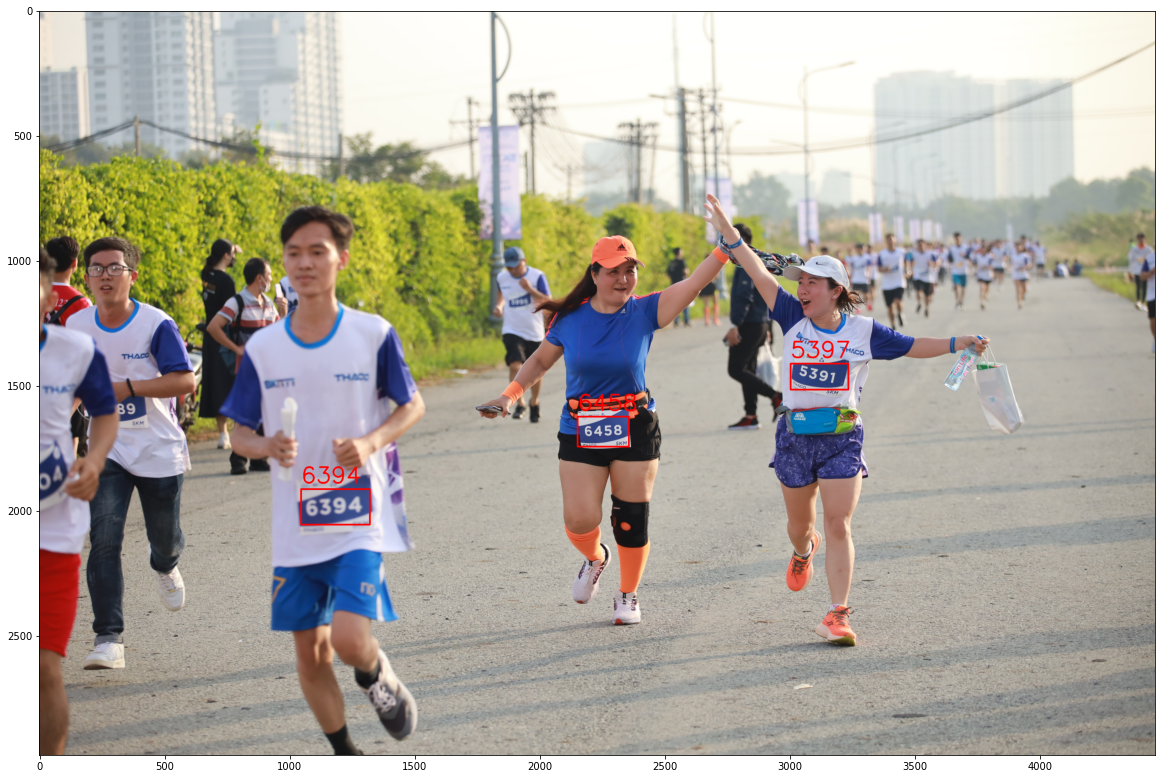

In [ ]:
# image = "1.jpg"
# image = "3KA_6492.JPG"
# image = "3KA_6434.JPG"
# image = "3KA_6436.JPG"
image = "PAKA7065.JPG"
output = "/content/drive/MyDrive/BK Marathon 2022/4. Hành Trình Chạy/" + image

output = "/content/drive/MyDrive/BK Marathon 2022/5. Về Đích/3KA_6621.JPG"

img = cv.imread(output)
# Because OpenCV stores images in BGR order instead of RGB.
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

output = get_rbns(img)
print("Output:", output)
if output:
    color = (255, 0, 0)
    for a in output:
      img = annotate(img, a, color)

plt.figure(figsize = (20,20))

plt.imshow(img)

In [ ]:
import glob 
# image_paths = glob.glob("/content/drive/MyDrive/BK Marathon 2022/4. Hành Trình Chạy/*")
image_paths = glob.glob("/content/drive/MyDrive/BK Marathon 2022/5. Về Đích/*")
image_paths = glob.glob("/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/*")

In [ ]:
len(image_paths)

298

In [ ]:
paths = set()
# for item in items:
#   paths.add(item["path"])

# len(items)

In [ ]:
import tqdm

items = []

for image in tqdm.tqdm(image_paths):
  if image in paths:
    continue
  else:
    paths.add(image)
  
  print(image)
  try:
    img = cv.imread(image)
    # Because OpenCV stores images in BGR order instead of RGB.
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    output = get_rbns(img)

    item = {
        "path": image,
        "output": output
    }
    items.append(item)
    print("Output:", output)
  except:
    pass

  0%|          | 0/298 [00:00<?, ?it/s]

/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5030.JPG


  0%|          | 1/298 [00:00<03:36,  1.37it/s]

Output: [[2435, [3083, 1967, 232, 118]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5031.JPG


  1%|          | 2/298 [00:01<03:24,  1.45it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5033.JPG


  1%|          | 3/298 [00:14<30:57,  6.30s/it]

Output: [[2435, [1981, 1815, 289, 144]], [4, [876, 1976, 756, 323]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5036.JPG


  1%|▏         | 4/298 [00:16<22:10,  4.53s/it]

Output: [[2795, [2120, 2036, 317, 134]], [2294, [2876, 1891, 295, 121]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5038.JPG


  2%|▏         | 5/298 [00:16<15:19,  3.14s/it]

Output: [[22931, [2194, 1988, 301, 177]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5040.JPG


  2%|▏         | 6/298 [00:17<10:58,  2.26s/it]

Output: [[2293, [2145, 1966, 268, 124]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5041.JPG


  2%|▏         | 7/298 [00:18<08:37,  1.78s/it]

Output: [[23923, [2152, 1379, 287, 137]], [2700, [3375, 1618, 217, 128]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5042.JPG


  3%|▎         | 8/298 [00:18<06:25,  1.33s/it]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5043.JPG


  3%|▎         | 9/298 [00:18<04:59,  1.04s/it]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5044.JPG


  3%|▎         | 10/298 [00:19<04:05,  1.17it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5047.JPG


  4%|▎         | 11/298 [00:19<03:37,  1.32it/s]

Output: [[79, [1174, 1716, 547, 181]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5048.JPG


  4%|▍         | 12/298 [00:20<03:32,  1.34it/s]

Output: [[2240, [2309, 1843, 252, 117]], [1, [389, 1706, 764, 375]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5050.JPG


  4%|▍         | 13/298 [00:21<03:13,  1.47it/s]

Output: [[2476, [2458, 1995, 306, 146]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5054.JPG


  5%|▍         | 14/298 [00:21<03:15,  1.46it/s]

Output: [[0, [628, 1661, 947, 365]], [115, [676, 2084, 858, 322]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5055.JPG


  5%|▌         | 15/298 [00:22<03:03,  1.54it/s]

Output: [[0, [1080, 1439, 431, 192]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5057.JPG


  5%|▌         | 16/298 [00:22<02:44,  1.72it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5058.JPG


  6%|▌         | 17/298 [00:23<02:26,  1.92it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5059.JPG


  6%|▌         | 18/298 [00:23<02:14,  2.09it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5060.JPG


  6%|▋         | 19/298 [00:23<02:04,  2.24it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5061.JPG


  7%|▋         | 20/298 [00:24<01:59,  2.33it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5062.JPG


  7%|▋         | 21/298 [00:24<01:54,  2.42it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5064.JPG


  7%|▋         | 22/298 [00:25<01:50,  2.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5065.JPG


  8%|▊         | 23/298 [00:25<01:50,  2.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5066.JPG


  8%|▊         | 24/298 [00:25<01:47,  2.54it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5067.JPG


  8%|▊         | 25/298 [00:26<01:46,  2.56it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5070.JPG


  9%|▊         | 26/298 [00:26<01:46,  2.57it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5078.JPG


  9%|▉         | 27/298 [00:27<01:46,  2.55it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5080.JPG


  9%|▉         | 28/298 [00:27<01:45,  2.55it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5081.JPG


 10%|▉         | 29/298 [00:27<01:46,  2.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5082.JPG


 10%|█         | 30/298 [00:28<01:59,  2.24it/s]

Output: [[2330, [287, 2006, 285, 281]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5083.JPG


 10%|█         | 31/298 [00:28<01:56,  2.30it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5085.JPG


 11%|█         | 32/298 [00:29<01:53,  2.34it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5086.JPG


 11%|█         | 33/298 [00:29<01:51,  2.39it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5088.JPG


 11%|█▏        | 34/298 [00:30<01:48,  2.43it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5090.JPG


 12%|█▏        | 35/298 [00:30<01:47,  2.45it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5093.JPG


 12%|█▏        | 36/298 [00:31<01:58,  2.21it/s]

Output: [[2294, [2012, 1596, 312, 206]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5104.JPG


 12%|█▏        | 37/298 [00:31<01:53,  2.30it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5105.JPG


 13%|█▎        | 38/298 [00:31<01:50,  2.36it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5106.JPG


 13%|█▎        | 39/298 [00:32<01:48,  2.38it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5108.JPG


 13%|█▎        | 40/298 [00:32<01:46,  2.43it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5110.JPG


 14%|█▍        | 41/298 [00:33<01:46,  2.41it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5112.JPG


 14%|█▍        | 42/298 [00:33<01:56,  2.20it/s]

Output: [[334, [695, 1834, 174, 146]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5114.JPG


 14%|█▍        | 43/298 [00:33<01:51,  2.28it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5116.JPG


 15%|█▍        | 44/298 [00:34<01:47,  2.37it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5118.JPG


 15%|█▌        | 45/298 [00:34<01:46,  2.39it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5119.JPG


 15%|█▌        | 46/298 [00:35<01:43,  2.44it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5121.JPG


 16%|█▌        | 47/298 [00:35<01:41,  2.48it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5122.JPG


 16%|█▌        | 48/298 [00:35<01:40,  2.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5124.JPG


 16%|█▋        | 49/298 [00:36<01:40,  2.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5129.JPG


 17%|█▋        | 50/298 [00:36<01:39,  2.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5131.JPG


 17%|█▋        | 51/298 [00:37<01:38,  2.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5133.JPG


 17%|█▋        | 52/298 [00:37<01:39,  2.48it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5134.JPG


 18%|█▊        | 53/298 [00:37<01:39,  2.47it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5135.JPG


 18%|█▊        | 54/298 [00:38<01:39,  2.46it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5137.JPG


 18%|█▊        | 55/298 [00:38<01:39,  2.44it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5140.JPG


 19%|█▉        | 56/298 [00:39<01:39,  2.43it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5141.JPG


 19%|█▉        | 57/298 [00:39<01:39,  2.43it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5142.JPG


 19%|█▉        | 58/298 [00:40<01:39,  2.40it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5143.JPG


 20%|█▉        | 59/298 [00:40<01:39,  2.41it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5146.JPG


 20%|██        | 60/298 [00:40<01:37,  2.44it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5149.JPG


 20%|██        | 61/298 [00:41<01:38,  2.41it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5150.JPG


 21%|██        | 62/298 [00:41<01:48,  2.17it/s]

Output: [[8, [2491, 2288, 204, 176]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5152.JPG


 21%|██        | 63/298 [00:42<01:56,  2.01it/s]

Output: [[532, [1063, 2423, 219, 153]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5154.JPG


 21%|██▏       | 64/298 [00:43<02:01,  1.93it/s]

Output: [[35, [2106, 2123, 312, 195]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5155.JPG


 22%|██▏       | 65/298 [00:43<02:05,  1.85it/s]

Output: [[2225, [3599, 2221, 265, 151]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5159.JPG


 22%|██▏       | 66/298 [00:43<01:54,  2.02it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5162.JPG


 22%|██▏       | 67/298 [00:44<01:59,  1.93it/s]

Output: [[2277, [710, 2851, 271, 117]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5164.JPG


 23%|██▎       | 68/298 [00:45<02:03,  1.86it/s]

Output: [[2338, [395, 2615, 290, 155]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5166.JPG


 23%|██▎       | 69/298 [00:45<01:53,  2.02it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5168.JPG


 23%|██▎       | 70/298 [00:45<01:46,  2.14it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5170.JPG


 24%|██▍       | 71/298 [00:46<01:42,  2.22it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5171.JPG


 24%|██▍       | 72/298 [00:46<01:38,  2.30it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5172.JPG


 24%|██▍       | 73/298 [00:47<01:36,  2.32it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5173.JPG


 25%|██▍       | 74/298 [00:47<01:34,  2.37it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5175.JPG


 25%|██▌       | 75/298 [00:47<01:33,  2.39it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5174.JPG


 26%|██▌       | 76/298 [00:48<01:32,  2.40it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5178.JPG


 26%|██▌       | 77/298 [00:48<01:31,  2.42it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5180.JPG


 26%|██▌       | 78/298 [00:49<01:30,  2.42it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5185.JPG


 27%|██▋       | 79/298 [00:49<01:30,  2.43it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5186.JPG


 27%|██▋       | 80/298 [00:50<01:28,  2.45it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5187.JPG


 27%|██▋       | 81/298 [00:50<01:39,  2.18it/s]

Output: [[254, [2139, 2227, 240, 171]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5188.JPG


 28%|██▊       | 82/298 [00:50<01:34,  2.28it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5190.JPG


 28%|██▊       | 83/298 [00:51<01:34,  2.28it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5191.JPG


 28%|██▊       | 84/298 [00:51<01:31,  2.34it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5192.JPG


 29%|██▊       | 85/298 [00:52<01:30,  2.36it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5193.JPG


 29%|██▉       | 86/298 [00:52<01:29,  2.38it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5194.JPG


 29%|██▉       | 87/298 [00:53<01:27,  2.41it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5195.JPG


 30%|██▉       | 88/298 [00:53<01:59,  1.75it/s]

Output: [[5678, [2999, 2072, 214, 179]], [58885, [3405, 2271, 259, 145]], [0, [751, 2899, 430, 79]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5198.JPG


 30%|██▉       | 89/298 [00:54<01:51,  1.87it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5200.JPG


 30%|███       | 90/298 [00:54<01:42,  2.03it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5201.JPG


 31%|███       | 91/298 [00:55<01:36,  2.14it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5202.JPG


 31%|███       | 92/298 [00:55<01:32,  2.22it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5204.JPG


 31%|███       | 93/298 [00:56<01:29,  2.29it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5205.JPG


 32%|███▏      | 94/298 [00:56<01:27,  2.34it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5208.JPG


 32%|███▏      | 95/298 [00:56<01:24,  2.40it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5209.JPG


 32%|███▏      | 96/298 [00:57<01:33,  2.17it/s]

Output: [[1155, [3985, 1556, 307, 160]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5212.JPG


 33%|███▎      | 97/298 [00:57<01:39,  2.02it/s]

Output: [[1931, [2236, 2021, 236, 116]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5213.JPG


 33%|███▎      | 98/298 [00:58<01:53,  1.77it/s]

Output: [[1931, [2185, 1979, 220, 116]], [1313, [3286, 1596, 270, 158]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5214.JPG


 33%|███▎      | 99/298 [00:59<01:52,  1.77it/s]

Output: [[1576, [3174, 1900, 302, 152]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5215.JPG


 34%|███▎      | 100/298 [00:59<01:42,  1.94it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5218.JPG


 34%|███▍      | 101/298 [01:00<01:43,  1.90it/s]

Output: [[127, [2277, 2143, 204, 158]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5219.JPG


 34%|███▍      | 102/298 [01:01<02:05,  1.57it/s]

Output: [[1524, [3204, 1905, 271, 162]], [1100, [1629, 2101, 250, 134]], [1096, [2340, 2016, 242, 112]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5222.JPG


 35%|███▍      | 103/298 [01:01<01:50,  1.77it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5223.JPG


 35%|███▍      | 104/298 [01:02<01:50,  1.76it/s]

Output: [[1533, [2713, 1555, 382, 188]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5225.JPG


 35%|███▌      | 105/298 [01:02<01:39,  1.94it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5227.JPG


 36%|███▌      | 106/298 [01:03<02:01,  1.58it/s]

Output: [[1535, [3699, 1671, 278, 142]], [1945, [1910, 2062, 264, 136]], [1938, [2864, 2216, 299, 178]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5229.JPG


 36%|███▌      | 107/298 [01:03<01:48,  1.76it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5230.JPG


 36%|███▌      | 108/298 [01:04<01:47,  1.77it/s]

Output: [[1153, [3370, 1197, 364, 190]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5231.JPG


 37%|███▋      | 109/298 [01:04<01:39,  1.90it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5234.JPG


 37%|███▋      | 110/298 [01:05<01:31,  2.06it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5236.JPG


 37%|███▋      | 111/298 [01:05<01:35,  1.95it/s]

Output: [[1286, [3152, 1127, 349, 172]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5237.JPG


 38%|███▊      | 112/298 [01:06<01:49,  1.71it/s]

Output: [[1975, [1351, 2192, 350, 180]], [1761, [240, 2062, 330, 179]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5242.JPG


 38%|███▊      | 113/298 [01:07<01:46,  1.74it/s]

Output: [[5805, [3012, 2640, 405, 189]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5243.JPG


 38%|███▊      | 114/298 [01:07<01:35,  1.92it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5245.JPG


 39%|███▊      | 115/298 [01:08<01:37,  1.87it/s]

Output: [[580, [538, 2150, 195, 203]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5247.JPG


 39%|███▉      | 116/298 [01:08<01:38,  1.84it/s]

Output: [[648, [3589, 1622, 263, 147]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5248.JPG


 39%|███▉      | 117/298 [01:09<01:31,  1.99it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5249.JPG


 40%|███▉      | 118/298 [01:09<01:25,  2.11it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5251.JPG


 40%|███▉      | 119/298 [01:09<01:20,  2.23it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5252.JPG


 40%|████      | 120/298 [01:10<01:26,  2.05it/s]

Output: [[6123, [3371, 1902, 189, 144]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5253.JPG


 41%|████      | 121/298 [01:11<01:39,  1.78it/s]

Output: [[5678, [3822, 1622, 309, 163]], [7, [118, 1548, 501, 172]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5254.JPG


 41%|████      | 122/298 [01:11<01:30,  1.95it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5258.JPG


 41%|████▏     | 123/298 [01:12<01:41,  1.72it/s]

Output: [[371, [922, 2140, 259, 147]], [1370, [2269, 1947, 248, 122]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5263.JPG


 42%|████▏     | 124/298 [01:12<01:40,  1.73it/s]

Output: [[1930, [1718, 1525, 205, 119]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5262.JPG


 42%|████▏     | 125/298 [01:13<01:31,  1.89it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5265.JPG


 42%|████▏     | 126/298 [01:13<01:32,  1.86it/s]

Output: [[1075, [1998, 2143, 416, 183]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5266.JPG


 43%|████▎     | 127/298 [01:14<01:33,  1.83it/s]

Output: [[1075, [2556, 1518, 201, 124]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5268.JPG


 43%|████▎     | 128/298 [01:14<01:33,  1.83it/s]

Output: [[1075, [2164, 2016, 287, 157]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5269.JPG


 43%|████▎     | 129/298 [01:15<01:25,  1.99it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5272.JPG


 44%|████▎     | 130/298 [01:15<01:18,  2.13it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5273.JPG


 44%|████▍     | 131/298 [01:16<01:15,  2.22it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5275.JPG


 44%|████▍     | 132/298 [01:16<01:12,  2.30it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5276.JPG


 45%|████▍     | 133/298 [01:16<01:09,  2.39it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5278.JPG


 45%|████▍     | 134/298 [01:17<01:07,  2.44it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5277.JPG


 45%|████▌     | 135/298 [01:17<01:05,  2.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5279.JPG


 46%|████▌     | 136/298 [01:18<01:04,  2.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5280.JPG


 46%|████▌     | 137/298 [01:18<01:03,  2.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5282.JPG


 46%|████▋     | 138/298 [01:19<01:11,  2.25it/s]

Output: [[5673, [3560, 1395, 183, 148]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5284.JPG


 47%|████▋     | 139/298 [01:19<01:07,  2.34it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5285.JPG


 47%|████▋     | 140/298 [01:19<01:05,  2.42it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5286.JPG


 47%|████▋     | 141/298 [01:20<01:04,  2.45it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5287.JPG


 48%|████▊     | 142/298 [01:21<01:25,  1.82it/s]

Output: [[5357, [2498, 1730, 305, 134]], [5649, [1461, 1322, 360, 160]], [5219, [21, 1450, 228, 139]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5288.JPG


 48%|████▊     | 143/298 [01:21<01:25,  1.82it/s]

Output: [[5357, [3284, 1647, 404, 171]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5290.JPG


 48%|████▊     | 144/298 [01:21<01:17,  1.99it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5293.JPG


 49%|████▊     | 145/298 [01:22<01:26,  1.76it/s]

Output: [[6168, [2251, 1900, 221, 134]], [61695, [2973, 2021, 279, 138]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5294.JPG


 49%|████▉     | 146/298 [01:23<01:41,  1.50it/s]

Output: [[6169, [3507, 2048, 292, 155]], [6168, [2590, 2057, 327, 163]], [6150, [1951, 1814, 273, 141]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5296.JPG


 49%|████▉     | 147/298 [01:24<01:28,  1.72it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5297.JPG


 50%|████▉     | 148/298 [01:24<01:19,  1.89it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5298.JPG


 50%|█████     | 149/298 [01:24<01:12,  2.06it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/CRUZ5300.JPG


 50%|█████     | 150/298 [01:25<01:07,  2.21it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6345.JPG


 51%|█████     | 151/298 [01:25<01:08,  2.16it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6347.JPG


 51%|█████     | 152/298 [01:26<01:08,  2.12it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6348.JPG


 51%|█████▏    | 153/298 [01:26<01:08,  2.11it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6351.JPG


 52%|█████▏    | 154/298 [01:27<01:09,  2.06it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6352.JPG


 52%|█████▏    | 155/298 [01:27<01:10,  2.03it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6356.JPG


 52%|█████▏    | 156/298 [01:28<01:09,  2.06it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6358.JPG


 53%|█████▎    | 157/298 [01:28<01:15,  1.87it/s]

Output: [[0, [2950, 260, 985, 355]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6360.JPG


 53%|█████▎    | 158/298 [01:29<01:21,  1.73it/s]

Output: [[0, [3050, 129, 1243, 500]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6361.JPG


 53%|█████▎    | 159/298 [01:30<01:23,  1.67it/s]

Output: [[0, [3092, 116, 1185, 466]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6362.JPG


 54%|█████▎    | 160/298 [01:30<01:19,  1.73it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6363.JPG


 54%|█████▍    | 161/298 [01:31<01:15,  1.81it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6364.JPG


 54%|█████▍    | 162/298 [01:31<01:13,  1.86it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6366.JPG


 55%|█████▍    | 163/298 [01:32<01:10,  1.91it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6367.JPG


 55%|█████▌    | 164/298 [01:32<01:09,  1.94it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6368.JPG


 55%|█████▌    | 165/298 [01:33<01:07,  1.97it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6369.JPG


 56%|█████▌    | 166/298 [01:33<01:06,  1.97it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6370.JPG


 56%|█████▌    | 167/298 [01:34<01:05,  2.00it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6372.JPG


 56%|█████▋    | 168/298 [01:34<01:04,  2.02it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6374.JPG


 57%|█████▋    | 169/298 [01:35<01:10,  1.83it/s]

Output: [[2, [2951, 1170, 1140, 306]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6377.JPG


 57%|█████▋    | 170/298 [01:35<01:07,  1.88it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6378.JPG


 57%|█████▋    | 171/298 [01:36<01:05,  1.95it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6379.JPG


 58%|█████▊    | 172/298 [01:36<01:03,  1.97it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6381.JPG


 58%|█████▊    | 173/298 [01:37<01:02,  2.00it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6382.JPG


 58%|█████▊    | 174/298 [01:37<01:01,  2.02it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6383.JPG


 59%|█████▊    | 175/298 [01:38<01:00,  2.02it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6384.JPG


 59%|█████▉    | 176/298 [01:38<01:00,  2.02it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6386.JPG


 59%|█████▉    | 177/298 [01:39<01:06,  1.83it/s]

Output: [[5678, [2042, 3381, 584, 284]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6387.JPG


 60%|█████▉    | 178/298 [01:39<01:04,  1.87it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/3KA_6392.JPG


 60%|██████    | 179/298 [01:40<01:01,  1.92it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6859.JPG


 60%|██████    | 180/298 [01:41<01:12,  1.62it/s]

Output: [[22, [3563, 1608, 1310, 323]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6860.JPG


 61%|██████    | 181/298 [01:41<01:13,  1.58it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6861.JPG


 61%|██████    | 182/298 [01:42<01:17,  1.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6862.JPG


 61%|██████▏   | 183/298 [01:43<01:16,  1.51it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6865.JPG


 62%|██████▏   | 184/298 [01:44<01:20,  1.41it/s]

Output: [[22, [3691, 1273, 1651, 373]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6866.JPG


 62%|██████▏   | 185/298 [01:44<01:17,  1.46it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6869.JPG


 62%|██████▏   | 186/298 [01:45<01:15,  1.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6872.JPG


 63%|██████▎   | 187/298 [01:45<01:12,  1.52it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6873.JPG


 63%|██████▎   | 188/298 [01:46<01:17,  1.42it/s]

Output: [[222, [3673, 1626, 1551, 355]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6875.JPG


 63%|██████▎   | 189/298 [01:47<01:20,  1.35it/s]

Output: [[2, [3606, 1589, 1480, 376]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6876.JPG


 64%|██████▍   | 190/298 [01:48<01:17,  1.40it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6877.JPG


 64%|██████▍   | 191/298 [01:48<01:14,  1.44it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6879.JPG


 64%|██████▍   | 192/298 [01:49<01:12,  1.46it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6880.JPG


 65%|██████▍   | 193/298 [01:50<01:11,  1.47it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6881.JPG


 65%|██████▌   | 194/298 [01:50<01:08,  1.51it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6883.JPG


 65%|██████▌   | 195/298 [01:51<01:08,  1.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6885.JPG


 66%|██████▌   | 196/298 [01:52<01:07,  1.51it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6886.JPG


 66%|██████▌   | 197/298 [01:52<01:10,  1.44it/s]

Output: [[5678, [1112, 3392, 444, 259]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6887.JPG


 66%|██████▋   | 198/298 [01:53<01:08,  1.46it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6888.JPG


 67%|██████▋   | 199/298 [01:54<01:17,  1.28it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6889.JPG


 67%|██████▋   | 200/298 [01:55<01:16,  1.28it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6890.JPG


 67%|██████▋   | 201/298 [01:55<01:10,  1.37it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6891.JPG


 68%|██████▊   | 202/298 [01:56<01:06,  1.45it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6892.JPG


 68%|██████▊   | 203/298 [01:57<01:04,  1.47it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6895.JPG


 68%|██████▊   | 204/298 [01:57<01:02,  1.51it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6896.JPG


 69%|██████▉   | 205/298 [01:58<01:02,  1.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6897.JPG


 69%|██████▉   | 206/298 [01:59<01:00,  1.52it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6898.JPG


 69%|██████▉   | 207/298 [01:59<00:59,  1.52it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6900.JPG


 70%|██████▉   | 208/298 [02:00<00:59,  1.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6901.JPG


 70%|███████   | 209/298 [02:01<00:57,  1.54it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6903.JPG


 70%|███████   | 210/298 [02:01<00:57,  1.54it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6904.JPG


 71%|███████   | 211/298 [02:02<00:56,  1.54it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6905.JPG


 71%|███████   | 212/298 [02:03<00:59,  1.45it/s]

Output: [[6555, [632, 3347, 467, 251]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6906.JPG


 71%|███████▏  | 213/298 [02:03<00:57,  1.47it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6907.JPG


 72%|███████▏  | 214/298 [02:04<00:56,  1.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6908.JPG


 72%|███████▏  | 215/298 [02:05<00:55,  1.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6910.JPG


 72%|███████▏  | 216/298 [02:05<00:58,  1.41it/s]

Output: [[0, [63, 2787, 306, 204]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6912.JPG


 73%|███████▎  | 217/298 [02:06<01:03,  1.27it/s]

Output: [[0, [34, 2905, 358, 192]], [0, [4913, 3276, 343, 225]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6913.JPG


 73%|███████▎  | 218/298 [02:07<01:02,  1.27it/s]

Output: [[476, [1440, 3770, 367, 222]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6914.JPG


 73%|███████▎  | 219/298 [02:08<00:58,  1.36it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6915.JPG


 74%|███████▍  | 220/298 [02:09<00:58,  1.34it/s]

Output: [[2249, [2366, 3979, 363, 215]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6919.JPG


 74%|███████▍  | 221/298 [02:09<00:54,  1.41it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6920.JPG


 74%|███████▍  | 222/298 [02:10<00:55,  1.37it/s]

Output: [[0, [4986, 3736, 300, 325]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6923.JPG


 75%|███████▍  | 223/298 [02:11<00:56,  1.34it/s]

Output: [[230, [2188, 3915, 365, 298]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6927.JPG


 75%|███████▌  | 224/298 [02:12<00:56,  1.31it/s]

Output: [[233, [2008, 3437, 260, 247]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6929.JPG


 76%|███████▌  | 225/298 [02:12<00:52,  1.40it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6930.JPG


 76%|███████▌  | 226/298 [02:13<00:52,  1.36it/s]

Output: [[1, [1677, 3034, 284, 220]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6932.JPG


 76%|███████▌  | 227/298 [02:14<00:49,  1.43it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6933.JPG


 77%|███████▋  | 228/298 [02:14<00:47,  1.48it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6935.JPG


 77%|███████▋  | 229/298 [02:15<00:49,  1.39it/s]

Output: [[2508, [2748, 3478, 319, 236]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6936.JPG


 77%|███████▋  | 230/298 [02:16<00:47,  1.43it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6937.JPG


 78%|███████▊  | 231/298 [02:17<00:51,  1.29it/s]

Output: [[7, [1456, 3315, 305, 229]], [3, [2792, 3400, 334, 298]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6938.JPG


 78%|███████▊  | 232/298 [02:17<00:47,  1.39it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6940.JPG


 78%|███████▊  | 233/298 [02:18<00:51,  1.27it/s]

Output: [[2405, [2321, 3583, 372, 205]], [230, [5086, 3936, 426, 222]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6941.JPG


 79%|███████▊  | 234/298 [02:19<00:46,  1.37it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6942.JPG


 79%|███████▉  | 235/298 [02:19<00:44,  1.43it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6943.JPG


 79%|███████▉  | 236/298 [02:20<00:41,  1.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6944.JPG


 80%|███████▉  | 237/298 [02:21<00:40,  1.51it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6945.JPG


 80%|███████▉  | 238/298 [02:21<00:39,  1.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6946.JPG


 80%|████████  | 239/298 [02:22<00:38,  1.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6948.JPG


 81%|████████  | 240/298 [02:23<00:38,  1.52it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6949.JPG


 81%|████████  | 241/298 [02:23<00:37,  1.52it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6950.JPG


 81%|████████  | 242/298 [02:24<00:36,  1.51it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6952.JPG


 82%|████████▏ | 243/298 [02:25<00:41,  1.33it/s]

Output: [[0, [2045, 2939, 314, 249]], [0, [3634, 2955, 260, 252]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6953.JPG


 82%|████████▏ | 244/298 [02:26<00:38,  1.40it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6955.JPG


 82%|████████▏ | 245/298 [02:26<00:36,  1.44it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6957.JPG


 83%|████████▎ | 246/298 [02:27<00:37,  1.37it/s]

Output: [[13, [2091, 3061, 276, 235]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6961.JPG


 83%|████████▎ | 247/298 [02:28<00:35,  1.44it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6964.JPG


 83%|████████▎ | 248/298 [02:28<00:34,  1.47it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6966.JPG


 84%|████████▎ | 249/298 [02:29<00:35,  1.39it/s]

Output: [[0, [3560, 1260, 1561, 388]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6968.JPG


 84%|████████▍ | 250/298 [02:30<00:35,  1.34it/s]

Output: [[22, [3700, 1088, 1504, 373]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6970.JPG


 84%|████████▍ | 251/298 [02:31<00:38,  1.22it/s]

Output: [[2, [3634, 1343, 1407, 359]], [0, [3019, 2010, 559, 223]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6972.JPG


 85%|████████▍ | 252/298 [02:31<00:35,  1.31it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6973.JPG


 85%|████████▍ | 253/298 [02:32<00:32,  1.39it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6975.JPG


 85%|████████▌ | 254/298 [02:33<00:30,  1.45it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6976.JPG


 86%|████████▌ | 255/298 [02:33<00:28,  1.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6977.JPG


 86%|████████▌ | 256/298 [02:34<00:27,  1.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6979.JPG


 86%|████████▌ | 257/298 [02:35<00:26,  1.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6980.JPG


 87%|████████▋ | 258/298 [02:35<00:25,  1.54it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6981.JPG


 87%|████████▋ | 259/298 [02:36<00:25,  1.55it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6982.JPG


 87%|████████▋ | 260/298 [02:37<00:24,  1.57it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6984.JPG


 88%|████████▊ | 261/298 [02:37<00:27,  1.35it/s]

Output: [[1182, [1393, 3704, 395, 254]], [480, [4957, 4075, 388, 236]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6985.JPG


 88%|████████▊ | 262/298 [02:38<00:25,  1.41it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6987.JPG


 88%|████████▊ | 263/298 [02:39<00:24,  1.44it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6989.JPG


 89%|████████▊ | 264/298 [02:39<00:23,  1.47it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6991.JPG


 89%|████████▉ | 265/298 [02:40<00:25,  1.29it/s]

Output: [[1190, [1699, 3496, 349, 200]], [189, [5259, 3745, 292, 154]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6992.JPG


 89%|████████▉ | 266/298 [02:41<00:25,  1.27it/s]

Output: [[1355, [1549, 3897, 332, 173]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6993.JPG


 90%|████████▉ | 267/298 [02:42<00:24,  1.28it/s]

Output: [[543, [2464, 4049, 330, 266]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6994.JPG


 90%|████████▉ | 268/298 [02:43<00:23,  1.26it/s]

Output: [[6, [4248, 3571, 266, 206]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6995.JPG


 90%|█████████ | 269/298 [02:43<00:21,  1.34it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6996.JPG


 91%|█████████ | 270/298 [02:44<00:19,  1.41it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6998.JPG


 91%|█████████ | 271/298 [02:45<00:18,  1.45it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA6999.JPG


 91%|█████████▏| 272/298 [02:46<00:18,  1.37it/s]

Output: [[198, [3929, 4148, 263, 264]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7001.JPG


 92%|█████████▏| 273/298 [02:46<00:17,  1.42it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7003.JPG


 92%|█████████▏| 274/298 [02:47<00:16,  1.45it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7004.JPG


 92%|█████████▏| 275/298 [02:47<00:15,  1.48it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7005.JPG


 93%|█████████▎| 276/298 [02:48<00:14,  1.51it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7006.JPG


 93%|█████████▎| 277/298 [02:49<00:13,  1.51it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7007.JPG


 93%|█████████▎| 278/298 [02:49<00:13,  1.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7008.JPG


 94%|█████████▎| 279/298 [02:50<00:12,  1.53it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7010.JPG


 94%|█████████▍| 280/298 [02:51<00:12,  1.43it/s]

Output: [[0, [3517, 903, 1361, 341]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7012.JPG


 94%|█████████▍| 281/298 [02:52<00:11,  1.47it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7013.JPG


 95%|█████████▍| 282/298 [02:52<00:10,  1.50it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7014.JPG


 95%|█████████▍| 283/298 [02:53<00:10,  1.42it/s]

Output: [[22, [4007, 682, 1808, 458]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7015.JPG


 95%|█████████▌| 284/298 [02:54<00:10,  1.36it/s]

Output: [[22, [3999, 665, 1741, 469]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7016.JPG


 96%|█████████▌| 285/298 [02:55<00:09,  1.33it/s]

Output: [[82022, [3836, 813, 1783, 412]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7019.JPG


 96%|█████████▌| 286/298 [02:55<00:08,  1.39it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7020.JPG


 96%|█████████▋| 287/298 [02:56<00:08,  1.35it/s]

Output: [[22, [4117, 302, 1836, 567]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7021.JPG


 97%|█████████▋| 288/298 [02:57<00:07,  1.31it/s]

Output: [[22, [3881, 899, 1770, 473]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7022.JPG


 97%|█████████▋| 289/298 [02:58<00:06,  1.29it/s]

Output: [[22, [3816, 867, 1830, 449]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7029.JPG


 97%|█████████▋| 290/298 [02:58<00:05,  1.36it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7030.JPG


 98%|█████████▊| 291/298 [02:59<00:04,  1.41it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7031.JPG


 98%|█████████▊| 292/298 [03:00<00:04,  1.46it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7032.JPG


 98%|█████████▊| 293/298 [03:00<00:03,  1.49it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7033.JPG


 99%|█████████▊| 294/298 [03:01<00:02,  1.40it/s]

Output: [[523, [1776, 3210, 271, 209]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7035.JPG


 99%|█████████▉| 295/298 [03:02<00:02,  1.46it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7036.JPG


 99%|█████████▉| 296/298 [03:02<00:01,  1.38it/s]

Output: [[502, [1755, 4153, 452, 247]]]
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7037.JPG


100%|█████████▉| 297/298 [03:03<00:00,  1.42it/s]

Output: None
/content/drive/MyDrive/BK Marathon 2022/3. Xuất Phát Đua/PAKA7039.JPG


100%|██████████| 298/298 [03:04<00:00,  1.62it/s]

Output: [[0, [1220, 3524, 344, 244]]]


In [ ]:
len(items), len([x for x in items if x["output"]])

(298, 91)

In [ ]:
import pandas as pd  

bib_data = []
for item in items:
  if not item["output"]:
    continue
  for d in item["output"]:
    bib_data.append({
        "path": item["path"],
        "bib": d[0]
    })

df = pd.DataFrame(bib_data)
df.to_csv("/content/drive/MyDrive/Colab Notebooks/bib_start.csv", index=False, encoding="utf-8-sig")

In [ ]:
df.head()

,path,bib
0,/content/drive/MyDrive/BK Marathon 2022/3. Xuấ...,2435
1,/content/drive/MyDrive/BK Marathon 2022/3. Xuấ...,2435
2,/content/drive/MyDrive/BK Marathon 2022/3. Xuấ...,4
3,/content/drive/MyDrive/BK Marathon 2022/3. Xuấ...,2795
4,/content/drive/MyDrive/BK Marathon 2022/3. Xuấ...,2294


In [ ]:
len(set(df.bib))

81

In [ ]:
# !apt-get install xattr > /dev/null
from subprocess import getoutput
from IPython.display import HTML

output = "/content/drive/MyDrive/BK Marathon 2022/5. Về Đích/3KA_6621.JPG"
def get_shareable_link(file_path):
  fid = getoutput("xattr -p 'user.drive.id' " + "'" + file_path + "'")
  print(fid)
  # make a link and display it

  url = f"https://drive.google.com/file/d/{fid}"

  return url


url = get_shareable_link(output)
HTML(f"<a href={url} target=_blank>file URL</a>")

1OfRt3m441f1qrA9SRhQXZiuFvVK3jWKq


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/bib_finish.csv"
df = pd.read_csv(path)
df["url"] = [get_shareable_link(p) for p in df.path]

df = df[["bib", "url", "path"]]
df.to_csv(path, index=False, encoding="utf-8-sig")

12c92KIcnO8rJE4EAflpsKy9jc5coe6y1
1IeWccVN4LxLfObB_HuXIM9kJagvKJRP0
1CehGSUu9IJm_CXH22k1tpeB-V_alQNJK
1u8DvHEQ2_4YH7Rq7h1qRcfdFfNEkar2i
1rU7ZPhbRzWrIllGtA52WogVYwJFT7ZNo
1Oh-WY-FkGTiJEPjaVIWaM_zqhnWf-AbE
1mPpLBNJk58kwfJHyjwah43ELo9CvcTsv
1kStkFIz22xJ2Mb4UjwwlbFUH7owH910f
1AagUKzT4s67iB2wK2no3R-zIYAXyO_it
1BMQ787ERZaF2Bsbu0uSgcpKYPpXzhJ6D
11kyOi3Zf774f0qTQreEFZtK73KjruEGZ
1ID-qKvkO9YleUg-YBqWKblsH5Q6KP4po
1d3WKYPRkf6QeKjl97pDX781K_CVUzGcU
1CUZA5gJAy2R6-kw_7ciyaD4dHRiQa2Un
1qbpgcFPmxOZ5rDbVsJpEuEK1ZEX2ekdf
1-UUvl07tgO38bZk_qyBpnFnox2geH9g6
1fL97TSLD5RpHenjhcKbmz9EU1HU_jz5Y
1L4G0AriHH7zJCrN4Wv3d7MSk0EVveya7
1cIpRqTBEH5bknNtPL-qoO3mLTYrPbVDw
1t9Z-PMlfhTdaNTCUzuY6aiictp3qayr7
1PagiBfNJYyhi6806J87TxtK_LQoKii0r
1g2NkxYRip0ERXbF8Mzzqn1nddhPOnb5M
1Vu2A7ahYFre7C2AHTl-CxhKz6l4_jZCp
1O6_y9ZaPIhslkoa6kAVvotC70lqcNot2
1HiZqk3qLK8zU4eVvRsSG6cqW2aPjMtci
1VMpLbWZD4fecOi8Prtw1C2MFLeI3Fvi-
1frdtIBrVY92RgLLajQXbm28nq3okqEqf
1kokV0cd97gSP7wTFojDpJuai46-wLCDZ
1qId5gSOiAB3nFxt7YSfz5bK7TUGsYGcI
1qId5gSOiAB3nF

In [ ]:
df.head()

,bib,url,path
0,248,https://drive.google.com/file/d/12c92KIcnO8rJE...,/content/drive/MyDrive/BK Marathon 2022/5. Về ...
1,1206,https://drive.google.com/file/d/1IeWccVN4LxLfO...,/content/drive/MyDrive/BK Marathon 2022/5. Về ...
2,206,https://drive.google.com/file/d/1CehGSUu9IJm_C...,/content/drive/MyDrive/BK Marathon 2022/5. Về ...
3,1202,https://drive.google.com/file/d/1u8DvHEQ2_4YH7...,/content/drive/MyDrive/BK Marathon 2022/5. Về ...
4,1202,https://drive.google.com/file/d/1rU7ZPhbRzWrIl...,/content/drive/MyDrive/BK Marathon 2022/5. Về ...
